<a href="https://colab.research.google.com/github/Ranjan00/Avinash-Ranjan/blob/master/Time_series_Phenology_MODIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Install Earth Engine and geemap
!pip install -q earthengine-api geemap

# Import required libraries
import ee
import geemap

# Authenticate Earth Engine (no project ID here)
ee.Authenticate()

# Initialize Earth Engine (project ID used here)
ee.Initialize(project='ee-akr')


In [60]:
def get_modis_evi_extended(year):
    # Jan 1 current year to June 30 next year
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year + 1, 6, 30)

    evi_collection = (ee.ImageCollection('MODIS/061/MOD13A1')
                      .filterDate(start_date, end_date)
                      .filterBounds(aoi)
                      .select('EVI')
                      .map(lambda img: img.multiply(0.0001).copyProperties(img, ["system:time_start"])))

    return evi_collection

# Example: Stack for phenology year 2001 (Jan 2001–June 2002)
evi_2001_extended = get_modis_evi_extended(2001)


In [23]:
# Function to get MODIS EVI from Jan 1 current year to June 30 next year
def get_modis_evi_extended(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year + 1, 6, 30)

    evi_collection = (ee.ImageCollection('MODIS/061/MOD13A1')
                      .filterDate(start_date, end_date)
                      .filterBounds(aoi)
                      .select('EVI')
                      .map(lambda img: img.multiply(0.0001).copyProperties(img, ["system:time_start"])))

    return evi_collection

# Function to convert EVI ImageCollection to a single multi-band image
def stack_evi_bands(evi_collection):
    def set_band_names(img):
        date = ee.Date(img.get('system:time_start')).format('YYYYMMdd')
        return img.rename(date)

    evi_collection_named = evi_collection.map(set_band_names)

    evi_list = evi_collection_named.toList(evi_collection_named.size())
    stacked = ee.Image(evi_list.get(0))

    def stack_bands(img, prev_img):
        return ee.Image(prev_img).addBands(ee.Image(img))

    stacked_image = ee.Image(evi_list.slice(1).iterate(stack_bands, stacked))

    return stacked_image

# Use the updated function to get EVI collection for year 2001 phenology window
evi_2001_extended = get_modis_evi_extended(2001)

# Stack the EVI collection into a multi-band image
evi_2001_stack = stack_evi_bands(evi_2001_extended)


In [38]:
# Example point inside AOI (longitude, latitude) – adjust to your area
sample_point = ee.Geometry.Point([87.57466, 25.16745])



In [39]:
# Get dictionary of band values at sample point
evi_dict = evi_2001_stack.reduceRegion(
    reducer=ee.Reducer.first(),  # get pixel value per band
    geometry=sample_point,
    scale=250,
    maxPixels=1e9
).getInfo()

# evi_dict now has keys as band names (dates) and values as EVI
# Extract dates and values as lists
band_names = list(evi_dict.keys())
evi_values = list(evi_dict.values())

# Sort by date for plotting
dates_and_vals = sorted(zip(band_names, evi_values), key=lambda x: x[0])

# Separate
dates_sorted = [d for d,v in dates_and_vals]
evi_sorted = [v for d,v in dates_and_vals]


In [40]:
import datetime

# Get dictionary of band values at sample point
evi_dict = evi_2001_stack.reduceRegion(
    reducer=ee.Reducer.first(),  # get pixel value per band
    geometry=sample_point,
    scale=250,
    maxPixels=1e9
).getInfo()

if evi_dict:
    # Extract dates and values as lists
    band_names = list(evi_dict.keys())
    evi_values = list(evi_dict.values())

    # Filter out None values (missing data)
    filtered = [(d,v) for d,v in zip(band_names, evi_values) if v is not None]

    # Sort by date
    dates_and_vals = sorted(filtered, key=lambda x: x[0])

    # Separate
    dates_sorted = [datetime.datetime.strptime(d, '%Y%m%d') for d,v in dates_and_vals]
    evi_sorted = [v for d,v in dates_and_vals]

    # Now dates_sorted and evi_sorted are ready for plotting or further analysis
else:
    print("No data found at sample point.")


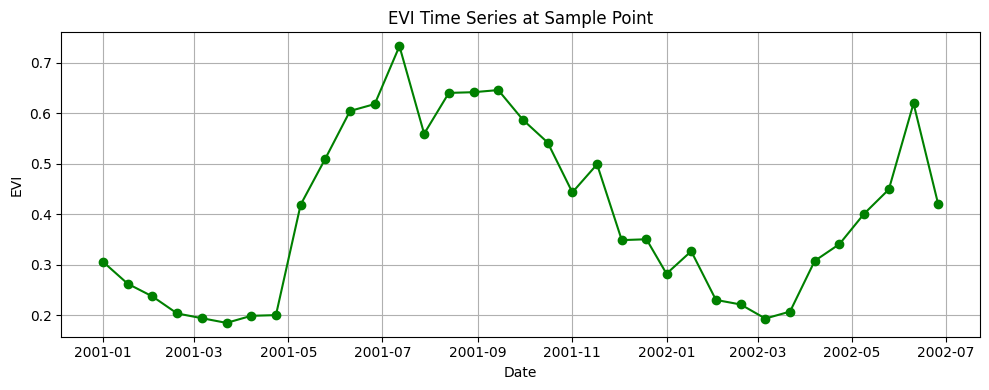

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame({
    'date': pd.to_datetime(band_names, format='%Y%m%d'),
    'EVI': evi_values
})

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['EVI'], marker='o', color='green')
plt.title('EVI Time Series at Sample Point')
plt.xlabel('Date')
plt.ylabel('EVI')
plt.grid(True)
plt.tight_layout()
plt.show()


In [76]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# Assume df contains 'date' and 'EVI' columns
df = df.copy()

# Step 1: Replace snow/invalid data (optional step: based on QA, not used here directly)
# Step 2: Remove outliers based on 3*SD around 7-point median
window = 7
med_rolling = df['EVI'].rolling(window=window, center=True, min_periods=1).median()
std_rolling = df['EVI'].rolling(window=window, center=True, min_periods=1).std()
mask_outliers = (np.abs(df['EVI'] - med_rolling) > 3 * std_rolling)

df['EVI_filtered'] = df['EVI']
df.loc[mask_outliers, 'EVI_filtered'] = np.nan

# Step 3: Replace NaNs and negative values via linear interpolation
evi_array = df['EVI_filtered'].to_numpy()
evi_array = np.where(np.isnan(evi_array) | (evi_array < 0), np.nan, evi_array)
nans, x = np.isnan(evi_array), lambda z: z.nonzero()[0]
evi_array[nans] = np.interp(x(nans), x(~nans), evi_array[~nans])

# Step 4: Smooth with Savitzky-Golay filter
evi_smooth = savgol_filter(evi_array, window_length=7, polyorder=2)


# Step 5: Phenology metrics extraction with different SOS/EOS thresholds
amp = evi_smooth.max() - evi_smooth.min()
sos_threshold = evi_smooth.min() + 0.3 * amp  # 30% for SOS
eos_threshold = evi_smooth.min() + 0.15 * amp  # 20% for EOS

# Peak of Season (POS)
pos_index = np.argmax(evi_smooth)
pos_date = df['date'].iloc[pos_index]

# Start of Season (SOS)
try:
    sos_index = next(i for i in range(pos_index) if evi_smooth[i] >= sos_threshold)
except StopIteration:
    sos_index = 0
sos_date = df['date'].iloc[sos_index]

# End of Season (EOS)
try:
    eos_index = pos_index + next(i for i, val in enumerate(evi_smooth[pos_index:]) if val <= eos_threshold)
except StopIteration:
    eos_index = len(evi_smooth) - 1
eos_date = df['date'].iloc[eos_index]


# Length of Season (LOS)
los_days = (eos_date - sos_date).days

# ✅ Ensure output is printed
print(f"\n📅 Phenology Metrics:")
print(f"Start of Season (SOS): {sos_date.date()}")
print(f"Peak of Season (POS): {pos_date.date()}")
print(f"End of Season (EOS): {eos_date.date()}")
print(f"Length of Season (LOS): {los_days} days")



📅 Phenology Metrics:
Start of Season (SOS): 2001-05-09
Peak of Season (POS): 2001-07-12
End of Season (EOS): 2002-02-18
Length of Season (LOS): 285 days


In [61]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# Assume df contains 'date' and 'EVI' columns
df = df.copy()

# Step 1: Replace snow/invalid data (optional step: based on QA, not used here directly)
# Step 2: Remove outliers based on 3*SD around 7-point median
window = 7
med_rolling = df['EVI'].rolling(window=window, center=True, min_periods=1).median()
std_rolling = df['EVI'].rolling(window=window, center=True, min_periods=1).std()
mask_outliers = (np.abs(df['EVI'] - med_rolling) > 3 * std_rolling)

df['EVI_filtered'] = df['EVI']
df.loc[mask_outliers, 'EVI_filtered'] = np.nan

# Step 3: Replace NaNs and negative values via linear interpolation
evi_array = df['EVI_filtered'].to_numpy()
evi_array = np.where(np.isnan(evi_array) | (evi_array < 0), np.nan, evi_array)
nans, x = np.isnan(evi_array), lambda z: z.nonzero()[0]
evi_array[nans] = np.interp(x(nans), x(~nans), evi_array[~nans])

# Step 4: Smooth with Savitzky-Golay filter
evi_smooth = savgol_filter(evi_array, window_length=7, polyorder=2)

# Step 5: Phenology metrics extraction
amp = evi_smooth.max() - evi_smooth.min()
threshold = evi_smooth.min() + 0.3 * amp

# Peak of Season (POS)
pos_index = np.argmax(evi_smooth)
pos_date = df['date'].iloc[pos_index]

# Start of Season (SOS)
try:
    sos_index = next(i for i in range(pos_index) if evi_smooth[i] >= threshold)
except StopIteration:
    sos_index = 0
sos_date = df['date'].iloc[sos_index]

# End of Season (EOS)
try:
    eos_index = pos_index + next(i for i, val in enumerate(evi_smooth[pos_index:]) if val <= threshold)
except StopIteration:
    eos_index = len(evi_smooth) - 1
eos_date = df['date'].iloc[eos_index]

# Length of Season (LOS)
los_days = (eos_date - sos_date).days

# Output
print(f"Start of Season (SOS): {sos_date.date()}")
print(f"Peak of Season (POS): {pos_date.date()}")
print(f"End of Season (EOS): {eos_date.date()}")
print(f"Length of Season (LOS): {los_days} days")


Start of Season (SOS): 2001-05-09
Peak of Season (POS): 2001-07-12
End of Season (EOS): 2002-01-01
Length of Season (LOS): 237 days


In [59]:
import numpy as np
from scipy.signal import savgol_filter

# Extract EVI values as numpy array
evi_array = np.array(df['EVI'])

# Handle missing or invalid values by interpolation or simple fill (optional)
# Here, we replace negative or nan values with nearest valid value
evi_array = np.where(np.isnan(evi_array) | (evi_array < 0), np.nan, evi_array)
nans, x= np.isnan(evi_array), lambda z: z.nonzero()[0]
evi_array[nans]= np.interp(x(nans), x(~nans), evi_array[~nans])

# Smooth using Savitzky-Golay filter (window=5, polyorder=2)
evi_smooth = savgol_filter(evi_array, window_length=7, polyorder=2)

# Define threshold for SOS and EOS as % of amplitude
amp = evi_smooth.max() - evi_smooth.min()
threshold = evi_smooth.min() + 0.3 * amp  # 20% above min EVI

# Find POS (peak of season)
pos_index = np.argmax(evi_smooth)
pos_date = df['date'].iloc[pos_index]

# Find SOS: first date before POS where EVI crosses threshold going up
try:
    sos_index = next(i for i in range(pos_index) if evi_smooth[i] >= threshold)
except StopIteration:
    sos_index = 0
sos_date = df['date'].iloc[sos_index]

# Find EOS: first date after POS where EVI crosses threshold going down
try:
    eos_index = pos_index + next(i for i, val in enumerate(evi_smooth[pos_index:]) if val <= threshold)
except StopIteration:
    eos_index = len(evi_smooth) - 1
eos_date = df['date'].iloc[eos_index]

# Calculate LOS (length of season) in days
los_days = (eos_date - sos_date).days

# Print results
print(f"Start of Season (SOS): {sos_date.date()}")
print(f"Peak of Season (POS): {pos_date.date()}")
print(f"End of Season (EOS): {eos_date.date()}")
print(f"Length of Season (LOS): {los_days} days")


Start of Season (SOS): 2001-05-09
Peak of Season (POS): 2001-07-12
End of Season (EOS): 2002-01-01
Length of Season (LOS): 237 days
